# Preprocessing data -- Chang MEG

Description of the process applied to Chang's MEG data. This explains which scripts to use to process MEG and how the conversion to dictionaries is carried out, as well as the filtering and scripts that have been applied. 

**IMPORTANT: the convention we are using in the dicitonary is as follows -- for all cortical regions, the hemisphere is denoted as 'LH/RH' followed by the name of the region in lower case letters with no spaces eg. 'LHinsula'**

## Preprocessing

### Making dictionaries

Data is converted in to dictionary form so that brain region labelling is not based solely upon order in a given file.

In the 'preprocess' module there is a function 'add_key_data' that takes a mat file of data, and also a txt file of the names of the brain regions in the corresponding correct order, and puts them together to create a dictionary. Note that this can be copied and modified to accept csv files with the dictionary names etc. 

This function is run by the script 'scripts/makedictionaries_Chang_data.py' and the dictionaries of data are saved out to hdf5 files. In the folders of Chang's data there are also coordinate files which are similarly processed to be placed in dictionary form.

These scripts can be modified to accept different input label files and different locations of data as required. 

### Filtering and performing transform to spectra

So far, this is carrying forward the same filter that was applied previously. As this is a slow process, the script 'preprocess/filter_Chang_data.py' has been applied to all of the dictionaries created above. The output is saved as dictionaries in the hdf5 files. 

Parameters for the 'filters.filter_MEG' function have been unchanged, and are recorded here: fsampling=600, fmin=2, fmax=45, regions =68. Within this, the multi-taper psd function is thus: tsa.multi_taper_psd(ds_q, Fs = fs/4, NW = 3, BW = 1, adaptive = False, jackknife = False)

Data is saved in files with the suffix '...filtered.h5' and the corresponding output frequencies are in '...filteredfreqs.h5'

## Loading and plotting the data

### Loading 

First, we will need the path of the data, and some of the functions from the utility modules. 

In [59]:
import sys
sys.path.append("..")

import numpy as np
import os
from utils import path as pth

MEG_path = '/Users/Megan/RajLab/MEG-chang' #insert appropriate path here.
directories = pth.walk_tree(MEG_path)

In [3]:
data = 'DK_timecourse_20_filtered.h5'
freqs = 'DK_timecourse_20_filterfreqs.h5'

In [7]:
dir = directories[0]
abspath = os.path.join(MEG_path,dir)
data_path = os.path.join(abspath, data)

In [8]:
FMEGdata = pth.read_hdf5(data_path)

In [9]:
freq_path = os.path.join(abspath, freqs)

In [10]:
f = pth.read_hdf5(freq_path)

In [11]:
type(FMEGdata) #just checking the format is what we expect.

dict

In [12]:
type(f)

numpy.ndarray

In [15]:
import matplotlib.pyplot as mpl
%matplotlib inline

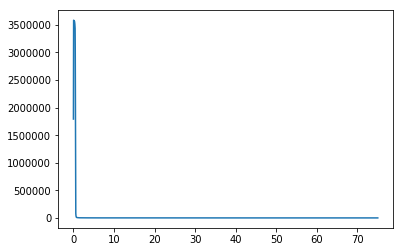

In [16]:
mpl.plot(f,FMEGdata['LHinsula'])

### Convert to dB and plot

The data needs to be converted to dB, using the utils/functions module.

In [17]:
from utils import functions

In [19]:
fmegdata = functions.mag2db(FMEGdata['LHinsula'])

Text(0,0,'LHinsula')

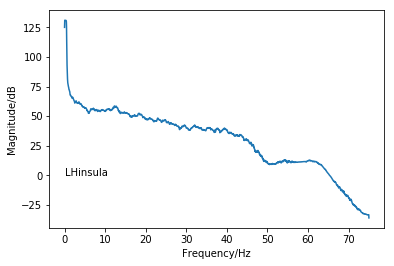

In [31]:
mpl.plot(f,fmegdata)
ax = mpl.gca()
ax.set_xlabel('Frequency/Hz')
ax.set_ylabel('Magnitude/dB')
ax.text(0,0,'LHinsula')

OK, for one subject we can plot these for the different brain regions. 

In [32]:
fmegdata_dict = {}
for key in FMEGdata.keys():
    fmegdata_dict[key] = functions.mag2db(FMEGdata[key])


Text(0,0.5,'Magnitude (dB)')

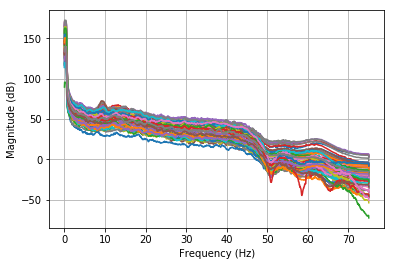

In [33]:
fig = mpl.figure(num=5, figsize = (6,4))
for key in fmegdata_dict.keys():
    mpl.plot(f,fmegdata_dict[key])

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

## Plotting for all subjects

We can now do this for a number of subjects.

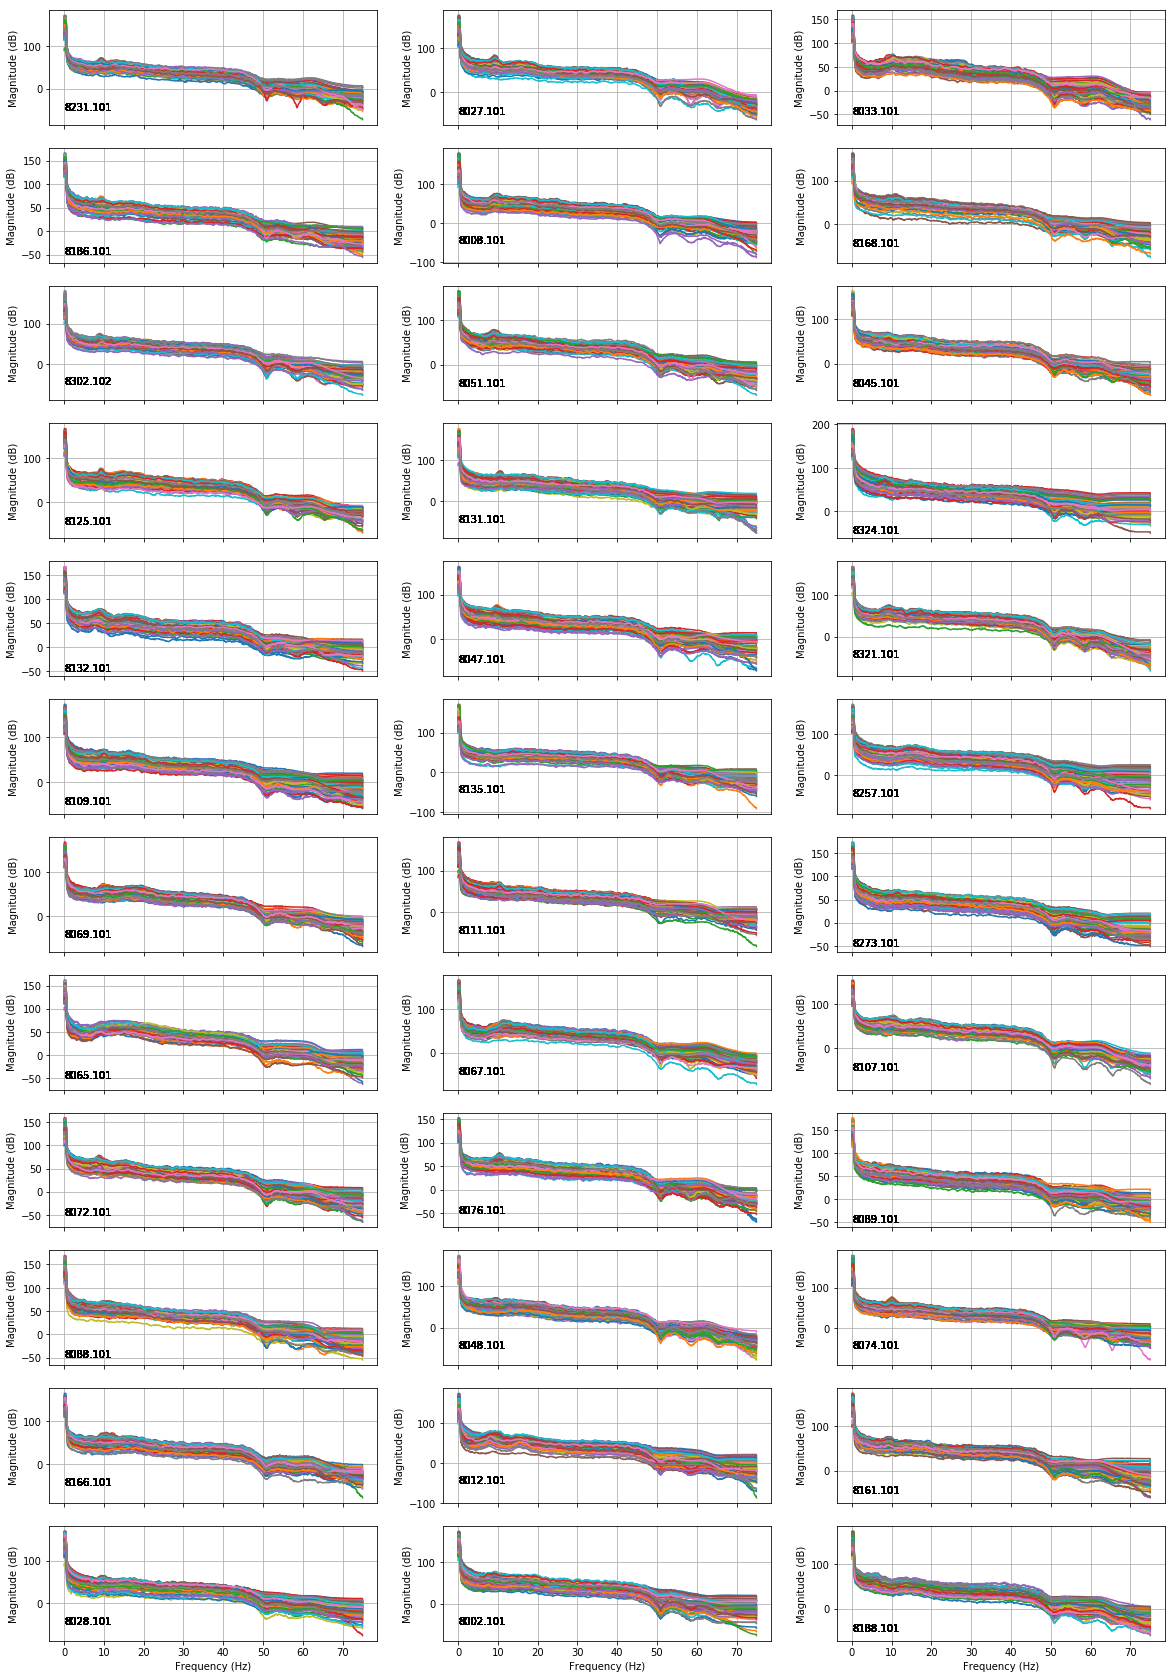

In [49]:
fig, axes = mpl.subplots(12,3, figsize = (20,30), sharex =True)
ax = axes.ravel()
i = 0
FMEGdata={}

for dir in directories:
    abspath = os.path.join(MEG_path,dir)
    data_path = os.path.join(abspath, data)
    FMEGdata[dir] = pth.read_hdf5(data_path)
    for key in FMEGdata[dir].keys():
        mpl.sca(ax[i])
        mpl.plot(f,functions.mag2db(FMEGdata[dir][key]))
        ax[i].grid(True)
        ax[i].set_ylabel('Magnitude (dB)')
        ax[i].text(0,-50,dir)
    if i >= 33:
        ax[i].set_xlabel('Frequency (Hz)')
    else:
        ax[i].set_xlabel('')
    i += 1

The data that has been used to fit thus far has been means of all brain regions, in the 2-45 Hz region, so let's plot that for all patients.

In [50]:
FMEGdata.keys() #the keys are the different patients -- the folder names

dict_keys(['8231.101', '8027.101', '8033.101', '8186.101', '8008.101', '8168.101', '8302.102', '8051.101', '8045.101', '8125.101', '8131.101', '8324.101', '8132.101', '8047.101', '8321.101', '8109.101', '8135.101', '8257.101', '8069.101', '8111.101', '8273.101', '8065.101', '8067.101', '8107.101', '8072.101', '8076.101', '8089.101', '8088.101', '8048.101', '8074.101', '8166.101', '8012.101', '8161.101', '8028.101', '8002.101', '8188.101'])

In [56]:
type(FMEGdata['8166.101'])

dict

For every entry in the dictionary of all patient data, we want to take a mean of that data across the brain regions. Let's make a function to do that. 

In [76]:
freq_number = len(f) #just checking sizes of various components
print(freq_number)

4488


In [112]:
def mean_dict(dictionary):
    dataarray = np.empty((68, freq_number))
    meanarray = np.empty((1, freq_number))
    patient_dict = {}
    FMEGmeans = {}
    for key in dictionary.keys():
        patient_dict = FMEGdata[key]
        #print(key)
        i = 0
        for region in patient_dict.keys():
            dataarray[i,:] = patient_dict[region]
            #print(region)
            i += 0
        meanarray[0,:] = np.mean(dataarray, axis = 0)
        FMEGmeans[key] = meanarray
    return FMEGmeans

In [113]:
FMEGmeans = mean_dict(FMEGdata)

In [114]:
FMEGmeans.keys()

dict_keys(['8231.101', '8027.101', '8033.101', '8186.101', '8008.101', '8168.101', '8302.102', '8051.101', '8045.101', '8125.101', '8131.101', '8324.101', '8132.101', '8047.101', '8321.101', '8109.101', '8135.101', '8257.101', '8069.101', '8111.101', '8273.101', '8065.101', '8067.101', '8107.101', '8072.101', '8076.101', '8089.101', '8088.101', '8048.101', '8074.101', '8166.101', '8012.101', '8161.101', '8028.101', '8002.101', '8188.101'])

In [99]:
patient = FMEGmeans['8028.101']
type(patient)
patient.shape

(1, 4488)

Also, let's make a function to take the mean for a single patient.

In [118]:
def mean_patient(data):
    FMEGmean = np.empty((1, freq_number))
    dataarray = np.empty((68, freq_number))
    i = 0
    for region in data.keys():
        dataarray[i,:] = data[region]
        i += 0
    FMEGmean = np.mean(dataarray, axis = 0)
    return FMEGmean

I want to also find the correct points in the freqency axis to use.

In [105]:
deltaf = f[1]-f[0]
print(2/deltaf)
print(45/deltaf)

119.65333333333334
2692.2


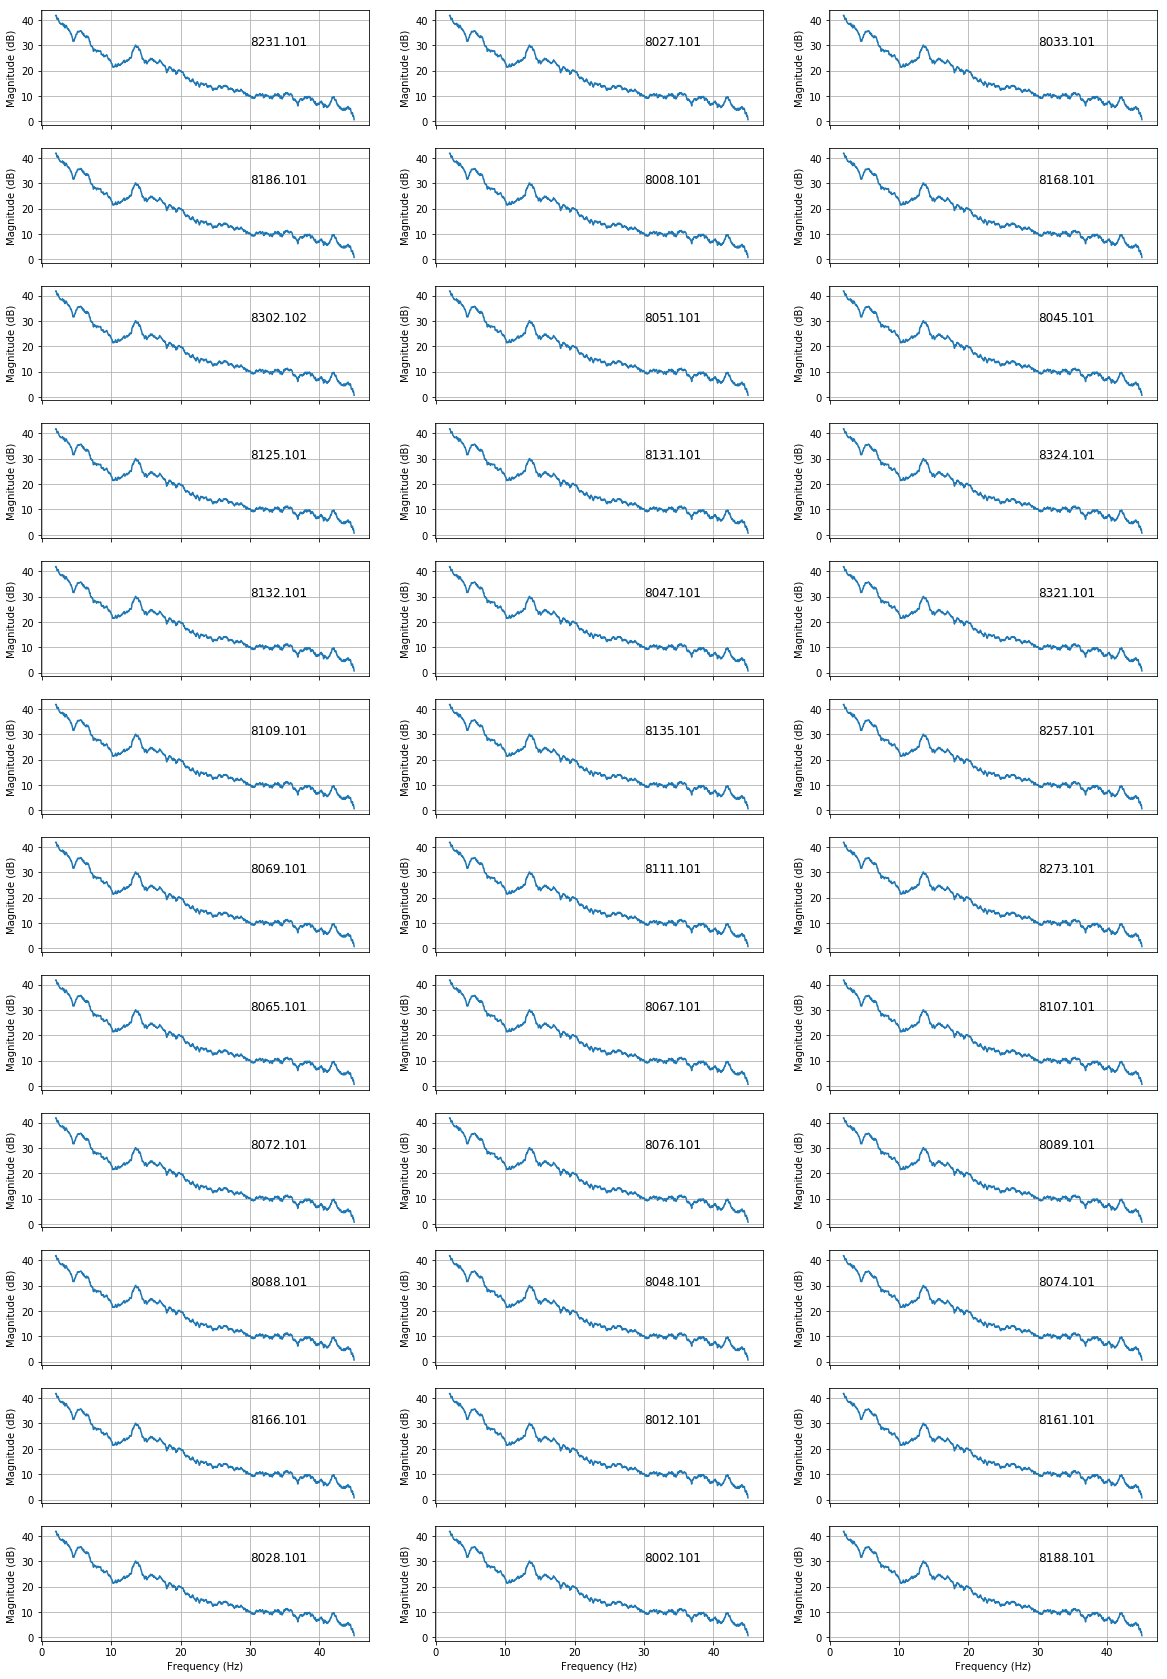

In [108]:
fig2, axes2 = mpl.subplots(12,3, figsize = (20,30), sharex =True)
ax2 = axes2.ravel()
i = 0

for dir in FMEGdata.keys():
    mpl.sca(ax2[i])
    mpl.plot(f[120:2693],functions.mag2db(FMEGmeans[dir][0][120:2693]))
    ax2[i].grid(True)
    ax2[i].set_ylabel('Magnitude (dB)')
    ax2[i].text(30,30,dir, fontsize = 'large')
    if i >= 33:
        ax2[i].set_xlabel('Frequency (Hz)')
    else:
        ax2[i].set_xlabel('')
    i += 1

Hmmm. Let's see if we can spot any variation between patients by overlaying them. 

Text(0,0.5,'Magnitude (dB)')

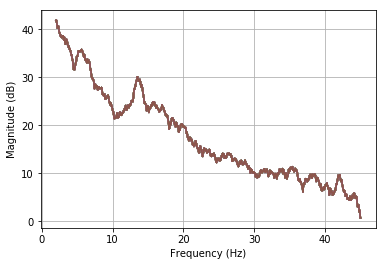

In [109]:
fig3 = mpl.figure(num=5, figsize = (6,4))
for dir in FMEGdata.keys():
    mpl.plot(f[120:2693],functions.mag2db(FMEGmeans[dir][0][120:2693]))

mpl.grid(True)
mpl.xlabel('Frequency (Hz)')
mpl.ylabel('Magnitude (dB)')

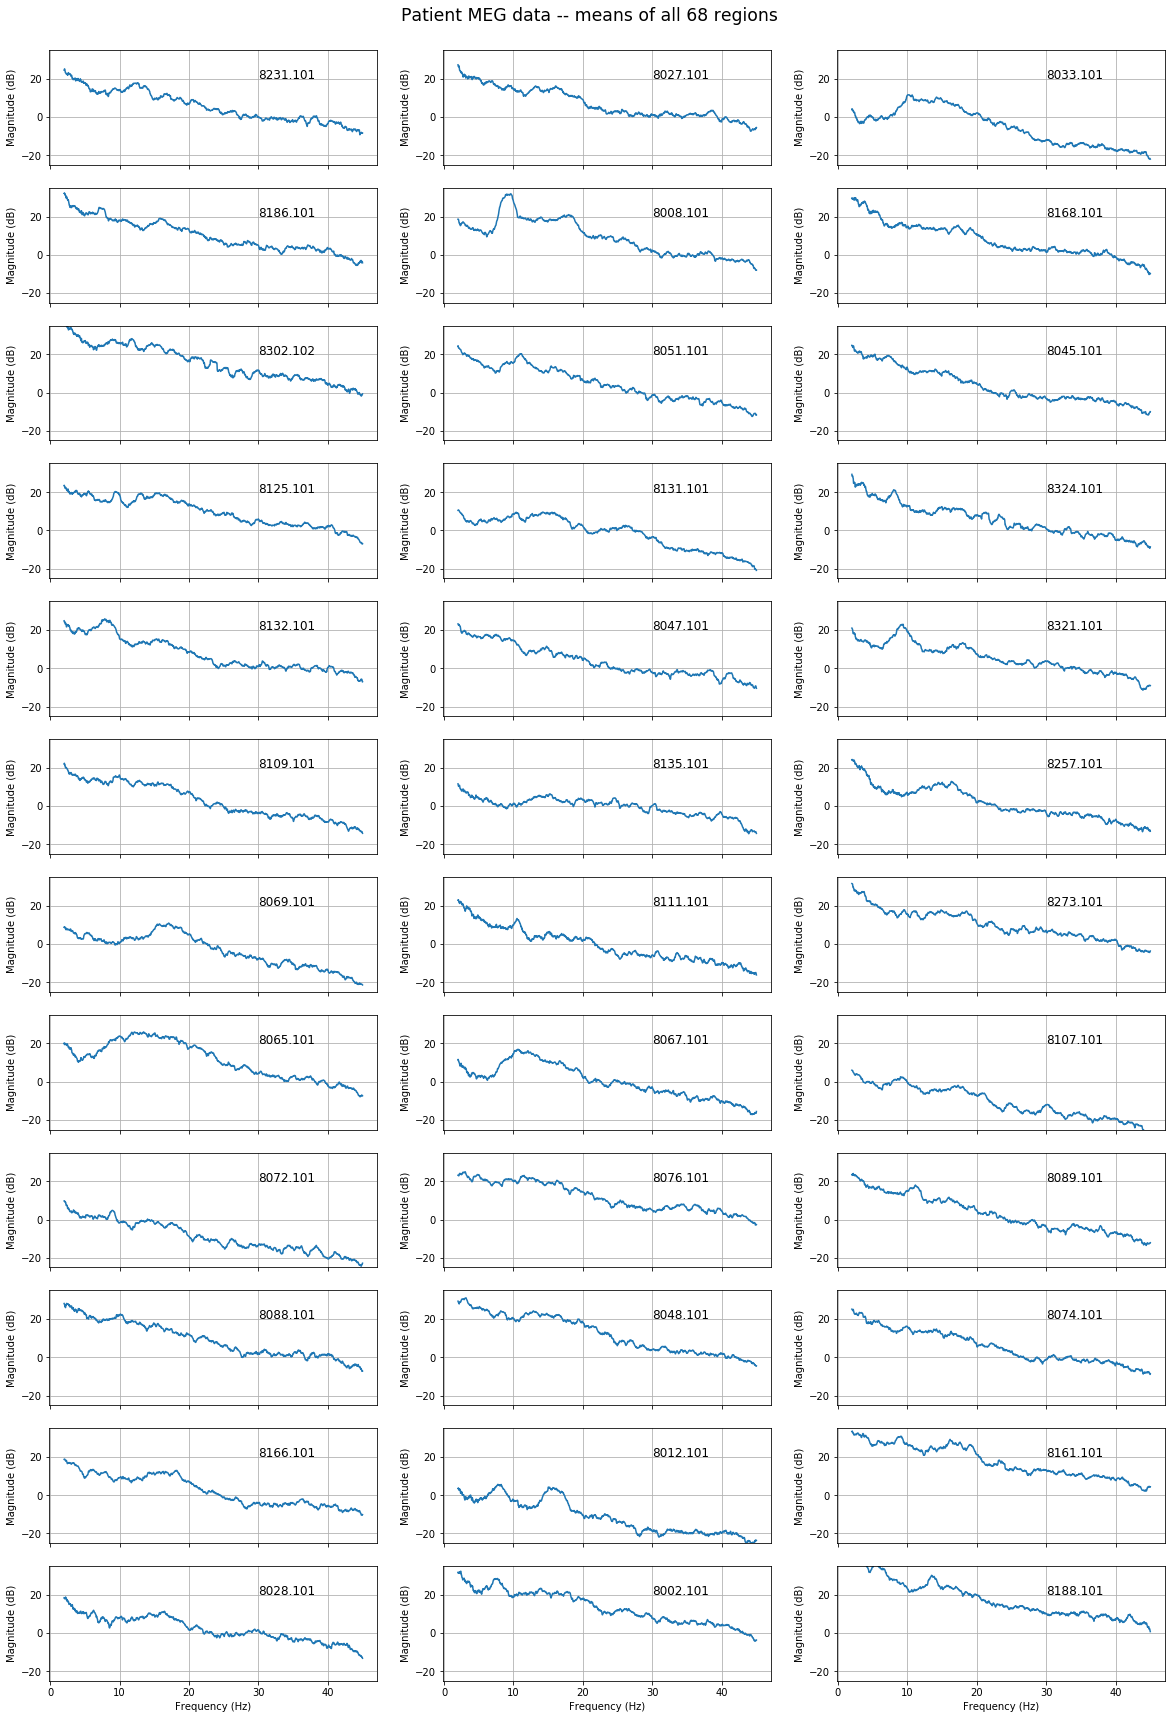

In [128]:
fig3, axes3 = mpl.subplots(12,3, figsize = (20,30), sharex =True)
ax3 = axes3.ravel()
fig3.suptitle('Patient MEG data -- means of all 68 regions', fontsize = 'xx-large', y = 0.9)
i = 0

for dir in FMEGdata.keys():
    mpl.sca(ax3[i])
    data = mean_patient(FMEGdata[dir])
    mpl.plot(f[120:2693],functions.mag2db(data[120:2693]))
    ax3[i].grid(True)
    ax3[i].set_ylabel('Magnitude (dB)')
    ax3[i].text(30,20,dir, fontsize = 'large')
    ax3[i].set_ylim(-25,35)
    if i >= 33:
        ax3[i].set_xlabel('Frequency (Hz)')
    else:
        ax3[i].set_xlabel('')
    i += 1
fig3.savefig("MEGmeans_allpatients.pdf", bbox_inches='tight')